In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
latent_size = 128
image_size = 784
init_size = 28/4 #initial size of generated image before upsampling
num_epochs = 30
batch_size = 64
sample_dir = 'samples'
save_dir = 'save'

In [3]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor()])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../data/',
                                   train=True,
                                   transform=transform)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)


tensor(0.)
tensor(1.)


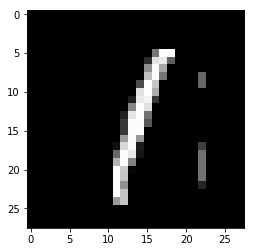

In [5]:
imgs, lbls = next(iter(data_loader))
imgs[0].data.shape
print(imgs.data.min())
print(imgs.data.max())
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

In [6]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=1, mean=False):
        super(Discriminator, self).__init__()
        self.minibatch_dis_in = 128
        self.minibatch_dis_out = 32
        self.minibatch_dis_kernel_dim = 8
        self.minibatch_dis_mean = mean
        self.T = nn.Parameter(torch.Tensor(self.minibatch_dis_in, 
                                          self.minibatch_dis_out,
                                          self.minibatch_dis_kernel_dim))
        nn.init.normal(self.T, 0, 1)
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(in_channels=4,out_channels=8,kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )
        self.l1 = nn.Sequential(
            nn.Linear(8*(28-2*2-2*2)**2,self.minibatch_dis_in),
            nn.ReLU(inplace=True),
#             nn.Linear(128,num_classes),
#             nn.Sigmoid()
        )
        
        self.l2 = nn.Sequential( 
            nn.Linear(self.minibatch_dis_out+self.minibatch_dis_in,num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.l1(x)
        
        matrices = x.mm(self.T.view(self.minibatch_dis_in, -1))
        matrices = matrices.view(-1, self.minibatch_dis_out, self.minibatch_dis_kernel_dim)
        
        M = matrices.unsqueeze(0)
        M_T = M.permute(1,0,2,3)
        norm = torch.abs(M-M_T).sum(3)
        expnorm = torch.exp(-norm)
        o_b = expnorm.sum(0)-1
        if self.minibatch_dis_mean:
            o_b /= x.size(0) -1
        
        x = torch.cat([x,o_b], 1)
        x = self.l2(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
#         self.l1 = nn.Sequential(nn.Linear(latent_size, int(8*init_size**2)))
        self.l1 = nn.Sequential(nn.Linear(latent_size, 256),
                                nn.Linear(256, int(16*init_size**2)))
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(8, 4, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(4, 1, 3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(1, 1, 3, stride=2, padding=1), # upsample then downsample to avoid poor image quality
            # nn.ReLU(inplace=True),
            # # this relu layer is the culprit of failed training attempts
            # # because it forces the sigmoid output to be >=0.5 which results in all grey images
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.l1(x)
        out = out.view(out.shape[0], 16, int(init_size), int(init_size))
        img = self.conv_blocks(out)
        return img

    
D = Discriminator()
G = Generator()
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=2e-5)
g_optimizer = torch.optim.Adam(G.parameters(), lr=2e-3)

In [7]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

Epoch 30 / 30 took 632.92 seconds
Total training time till this epoch was 20086.15 seconds


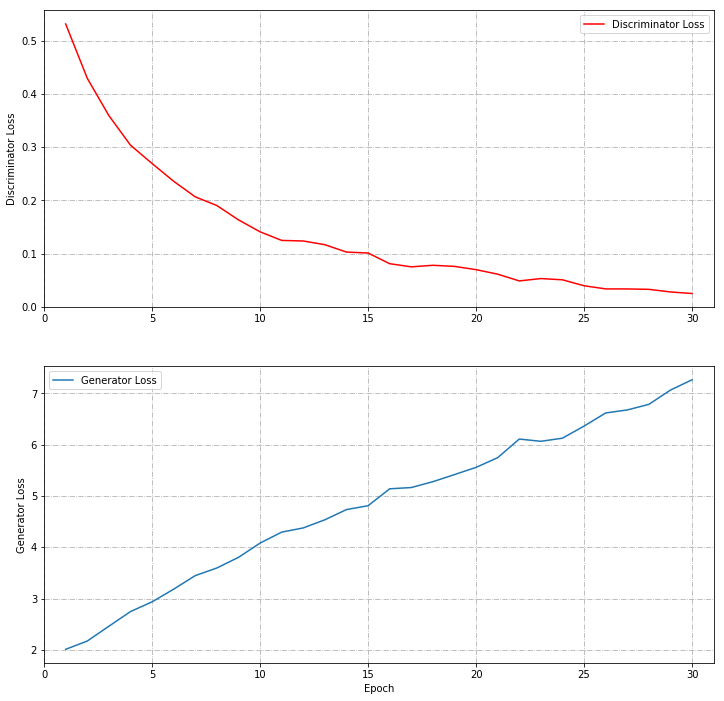

In [8]:
# Statistics to be saved
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)
real_scores = np.zeros(num_epochs)
fake_scores = np.zeros(num_epochs)

# Start training
start_time = time.time()
total_step = len(data_loader)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    for i, (images, _) in enumerate(data_loader):
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(images.size(0), 1)
        fake_labels = torch.zeros(images.size(0), 1)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        reset_grad()
        z = torch.randn(images.size(0), latent_size)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        # If D is trained so well, then don't update
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        reset_grad()
        z = torch.randn(batch_size, latent_size)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        real_labels = torch.ones(fake_images.size(0), 1)
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        g_loss.backward()
        g_optimizer.step()
        # =================================================================== #
        #                          Update Statistics                          #
        # =================================================================== #
        d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss.item()*(1./(i+1.))
        g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss.item()*(1./(i+1.))
        real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().item()*(1./(i+1.))
        fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().item()*(1./(i+1.))
    
    clear_output(wait=True)
    print('Epoch %d / %d took %6.2f seconds' % (epoch+1, num_epochs, time.time()-epoch_start_time))
    print('Total training time till this epoch was %8.2f seconds' % (time.time()-start_time))
    # Save real images
    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, 28, 28)
        save_image(1-images.data, os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_image(1-fake_images.data, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    
    plt.figure(figsize=(12,12))
    plt.subplot(2,1,1)
    ax = plt.gca()
    ax.set_xlim([0, num_epochs + 1])
    plt.ylabel('Discriminator Loss')
    plt.plot(range(1, epoch + 2), d_losses[:epoch+1], 'r', label='Discriminator Loss')
    ax.grid(linestyle='-.')
    plt.legend()
    plt.subplot(2,1,2)
    ax = plt.gca()
    ax.set_xlim([0, num_epochs + 1])
    plt.ylabel('Generator Loss')
    plt.xlabel('Epoch')
    plt.plot(range(1, epoch + 2), g_losses[:epoch+1], label='Generator Loss')    
    plt.legend()
    ax.grid(linestyle='-.')
    plt.show()

    # Save model at checkpoints
    if (epoch+1) % 10 == 0:
        torch.save(G.state_dict(), os.path.join(save_dir, 'G--{}.ckpt'.format(epoch+1)))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D--{}.ckpt'.format(epoch+1)))


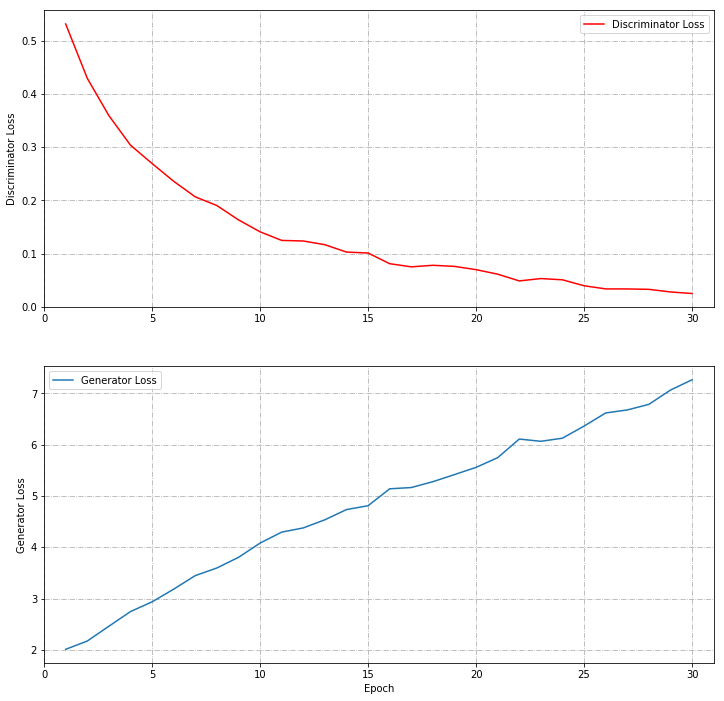

<Figure size 432x288 with 0 Axes>

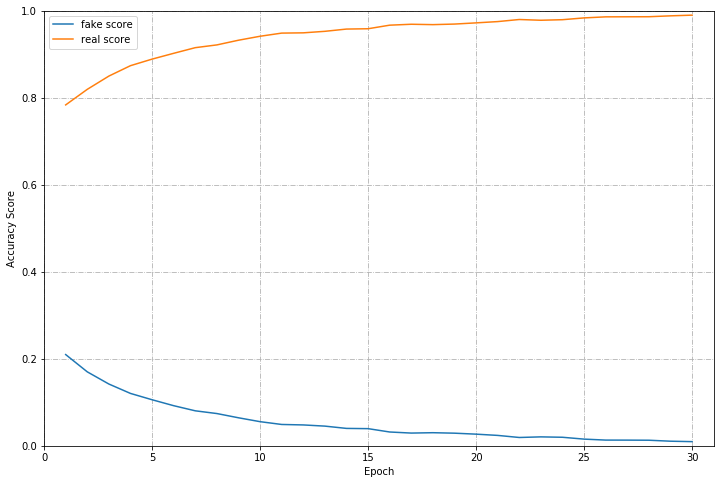

In [9]:
np.save(os.path.join(save_dir, 'd_losses.npy'), d_losses)
np.save(os.path.join(save_dir, 'g_losses.npy'), g_losses)
np.save(os.path.join(save_dir, 'fake_scores.npy'), fake_scores)
np.save(os.path.join(save_dir, 'real_scores.npy'), real_scores)

plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, num_epochs + 1])
plt.ylabel('Discriminator Loss')
plt.plot(range(1, epoch + 2), d_losses[:epoch+1], 'r', label='Discriminator Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, num_epochs + 1])
plt.ylabel('Generator Loss')
plt.xlabel('Epoch')
plt.plot(range(1, epoch + 2), g_losses[:epoch+1], label='Generator Loss')    
plt.legend()
ax.grid(linestyle='-.')
plt.show()
plt.savefig(os.path.join(save_dir, 'loss.png'))


plt.figure(figsize=(12,8))
ax = plt.gca()
ax.set_xlim([0, num_epochs + 1])
ax.set_ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.plot(range(1, num_epochs + 1), fake_scores, label='fake score')
plt.plot(range(1, num_epochs + 1), real_scores, label='real score')    
plt.legend()
ax.grid(linestyle='-.')
plt.savefig(os.path.join(save_dir, 'accuracy.png'))